# Valutazione dell'affidabilità dei sensori Lidar simulati 

## Librerie necessarie
In questo notebook vengono utilizzate le seguenti librerie:

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

## Funzioni per il plot delle traiettorie

plot_trajectory() mostra l'andamento della traiettoria passata in input.
plot_all_trajectories() mostra l'andamento di tutte le traiettorie passate in input, utilizzando lo stesso grafico

In [ ]:
def plot_trajectory(trajectory, name):
    # * plot trajectory
    plt.plot(trajectory["x"], trajectory["y"], label=name)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()


def plot_all_trajectories(trajectories):
    # * plot all trajectories
    for label in trajectories:
        trajectory = trajectories[label]
        plt.plot(trajectory["x"], trajectory["y"], label=label)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

## Funzione per il plot delle nuvole di punti 

In [ ]:
def plot_3d_points(
    clouds, colors, labels, elev=30, azim=-30, alphas=None, title=None, file_name=None
):
    if alphas is None:
        alphas = [1 for _ in clouds]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    for i, cloud in enumerate(clouds):
        x, y, z = cloud
        ax.scatter(x, y, z, c=colors[i], marker=".", label=labels[i], alpha=alphas[i])
    ax.set_box_aspect([1, 1, 1])
    # * rotazione di default: ax.view_init(elev=30, azim=-60)
    ax.view_init(elev=elev, azim=azim)

    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    if title is not None:
        ax.set_title(title)
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()

## Funzioni utili  
build_sphere costruisce una sfera e ritora i punti che la compongono, divisi in x, y e z

In [ ]:
def build_sphere(radius=5, position=(0, 0, 0), traslation=(0, 0, 0)):
    phi = np.linspace(0, np.pi, 100)
    theta = np.linspace(0, 2 * np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)

    x = radius * np.sin(phi) * np.cos(theta) + position[0] + traslation[0]
    y = radius * np.sin(phi) * np.sin(theta) + position[1] + traslation[1]
    z = radius * np.cos(phi) + position[2] + traslation[2]

    return x, y, z


def center_trajectory(trajectory):
    plot_trajectory(trajectory, "before")
    x_coords = trajectory["x"]
    y_coords = trajectory["y"]

    centroid_x = np.mean(x_coords)
    centroid_y = np.mean(y_coords)

    translation_x = -centroid_x
    translation_y = -centroid_y

    x_coords_trasl = x_coords + translation_x
    y_coords_trasl = y_coords + translation_y

    trajectory["x"] = x_coords_trasl
    trajectory["y"] = y_coords_trasl
    plot_trajectory(trajectory, "after")


def center_and_trim_trajectory(trajectory):
    center_x = np.mean(trajectory["x"])
    center_y = np.mean(trajectory["y"])

    trajectory["x"] -= center_x
    trajectory["y"] -= center_y

    if trajectory["label"].iloc[0] == "Trajectory_3":
        return trajectory[(trajectory["x"] > -40) & (trajectory["x"] < 40)]
    if trajectory["label"].iloc[0] == "Trajectory_2":
        return trajectory[(trajectory["y"] > -150) & (trajectory["y"] < 150)]
    if trajectory["label"].iloc[0] == "Trajectory_1":
        return trajectory[(trajectory["y"] > -100) & (trajectory["y"] < 100)]

    return trajectory

## Plot delle traiettorie da un Dataframe   

In [ ]:

# * leggi i dati dal file csv e salva tutte le labels di riconoscimenti delle traiettorie in un array
vehicle_loc_rot = pd.read_csv("vehicle_trajectories.csv")
labels = vehicle_loc_rot["label"].unique()

# * test plot_all_trajectories per plottare tutte le traiettorie
trajectories = {}
for label in labels:
    trajectory = vehicle_loc_rot[vehicle_loc_rot["label"] == label].reset_index(
        drop=True
    )
    trajectories[label] = trajectory
plot_all_trajectories(trajectories)


## Centering e trimming delle traiettorie

All'interno di `scan.py`, la traiettoria viene centrata nello spazio tridimensionale e accoricata, in modo che il posizionamento dei sensori sia facilitato.


In [ ]:
df = pd.read_csv("vehicle_trajectories.csv")
df_trimmed = df.groupby("label").apply(center_and_trim_trajectory).reset_index(drop=True)
df_trimmed['time'] = df_trimmed.groupby('label')['time'].transform(lambda x: x - x.min())

# plot_trajectory(df_trimmed[df_trimmed["label"] == "Trajectory_3"].reset_index(
#         drop=True
#     ), "after")

df_trimmed.to_csv("vehicle_keyframes.csv", index=False)

trajectories = {}
for label in labels:
    trajectory = df_trimmed[df_trimmed["label"] == label].reset_index(
        drop=True
    )
    trajectories[label] = trajectory
plot_all_trajectories(trajectories)

## Verifica affidabilità della simulazione

Attraverso la simulazione di una sfera e di un sensore Lidar all'interno dell'ambiente di Blender, sono state generate le nuvole di punti archiviate nei file `scan_sphere.csv` e `scan_sphere_trasl.csv`. Tali file rappresentano rispettivamente la sfera prima e dopo il suo spostamento nello spazio tridimensionale.

La sfera, costruita per rispecchiare fedelmente le dimensioni della sua controparte simulata, è stata posizionata nello spazio in modo analogo a quanto simulato in precedenza. Successivamente, la sfera è stata traslata seguendo un procedimento analogo a quello precedentemente simulato.

Attraverso l'utilizzo della libreria Matplotlib, sono stati generati due grafici distinti:
1. Il primo grafico offre una visualizzazione della sfera simulata e della sfera traslata, consentendo una valutazione visiva delle analogie tra le due situazioni.
2. Il secondo grafico presenta le nuvole di punti estratte dai file CSV.

In [ ]:

scan = pd.read_csv("scan_sphere.csv")
x_scan = scan["x"]
y_scan = scan["y"]
z_scan = scan["z"]

scan_trasl = pd.read_csv("scan_sphere_trasl.csv")
x_scan_trasl = scan_trasl["x"]
y_scan_trasl = scan_trasl["y"]
z_scan_trasl = scan_trasl["z"]

x_sphere, y_sphere, z_sphere = build_sphere(
    radius=2, position=(0, 6, -7), traslation=(0, 0, 0)
)
x_sphere_trasl, y_sphere_trasl, z_sphere_trasl = build_sphere(
    radius=2, position=(0, 6, -7), traslation=(0, -2, 1)
)

plot_3d_points(
    [(x_scan, y_scan, z_scan), (x_scan_trasl, y_scan_trasl, z_scan_trasl)],
    colors=["blue", "red"],
    labels=["prima della traslazione", "dopo la traslazione"],
    file_name="jupyter_plots/scan_sphere.png",
)

plot_3d_points(
    [(x_sphere, y_sphere, z_sphere), (x_sphere_trasl, y_sphere_trasl, z_sphere_trasl)],
    colors=["green", "orange"],
    labels=["prima della traslazione", "dopo la traslazione"],
    file_name="jupyter_plots/sphere.png",
)


Nel contesto di situazioni simili create, ci si aspetta che i due grafici siano compatibili, a condizione che la simulazione dei sensori Lidar sia accurata. Tale analisi visiva costituisce un mezzo per valutare la coerenza tra la simulazione e le situazioni reali rappresentate attraverso i dati dei sensori Lidar.

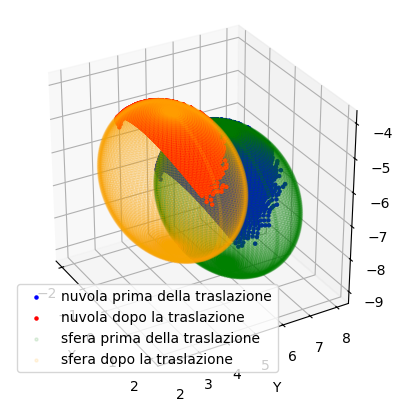

In [11]:

plot_3d_points(
    [
        (x_scan, y_scan, z_scan),
        (x_scan_trasl, y_scan_trasl, z_scan_trasl),
        (x_sphere, y_sphere, z_sphere),
        (x_sphere_trasl, y_sphere_trasl, z_sphere_trasl),
    ],
    colors=["blue", "red", "green", "orange"],
    labels=[
        "nuvola prima della traslazione",
        "nuvola dopo la traslazione",
        "sfera prima della traslazione",
        "sfera dopo la traslazione",
    ],
    alphas=[1, 1, 0.1, 0.1],
    file_name="jupyter_plots/overlap.png",
)

## Analisi delle nuvole di punti di un sensore Lidar in uno scenario con veicolo

Di seguito plottiamo i dati raccolti da un sensore Lidar in uno scenario con veicolo. La traiettoria in questione è formata da 80 timestep ed è una di quelle riportante sopra (a forma di "S"). 

In [12]:
# for i in range(40):
#     # * esamino i dati a intervall di 2 timestep
#     if i % 1 == 0:
#         scan = pd.read_csv(f"scans/csv/camera_1_{i}.csv")
#         x_scan = scan["x"]
#         y_scan = scan["y"]
#         z_scan = scan["z"]
#         plot_3d_points(
#             [(x_scan, y_scan, z_scan)],
#             colors=["blue"],
#             labels=["nuvola"],
#             title=f"timestep {i}",
#             elev=45,
#             azim=180,
#             file_name=f"jupyter_plots/scan_{i}.png",
#         )